# House Sales in King County

## Author: Piotr Grabysz

## Date: 26.03.2021

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

The dataset consists of 21613 rows and 21 columns, which include variables as number of bathrooms, bedrooms, year of built etc.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
house_data = pd.read_csv("kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


What are the prices?

In [13]:
house_data["price"].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

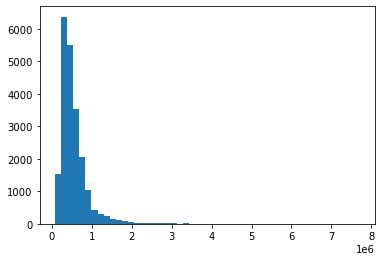

In [18]:
plt.hist(house_data["price"], bins = 50)
plt.show()

The mean price is 540,000\\$ and 75\% of the houses cost below 645,000\\$.
But there are some rare examples, where the price is extremaly high, with the maximum of nearly 8,000,000\$. This outliers *might* cause some problems, because their behaviour and dependency on the other variables might be different than it is for 'average' houses.

## Training XGBoost

### Train test split

Because the range of house prices is very large, I want to split the dataset in stratified fashion such that both train and test dataset contains similar amount of very cheap and very expensive houses.

In [3]:
X = house_data.drop(["id", "price", "date"], axis = 1)
y = house_data["price"]

y_binned = y.apply(lambda x: round(x/1e+5) if x<2e+6 else 21)
bins = y_binned.unique().tolist()
bins.sort()
print(f"y_binned contains prices divided into {len(bins)} groups: {bins}")

y_binned contains prices divided into 21 groups: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size = 0.3, stratify = y_binned, random_state = 1)

# now y_train is splitted y_binned. I want y, but with indexes from splitted y_binned
y_train = y.iloc[y_train.index]
y_test = y.iloc[y_test.index]

Lets see if my train test split seems to be stratified:

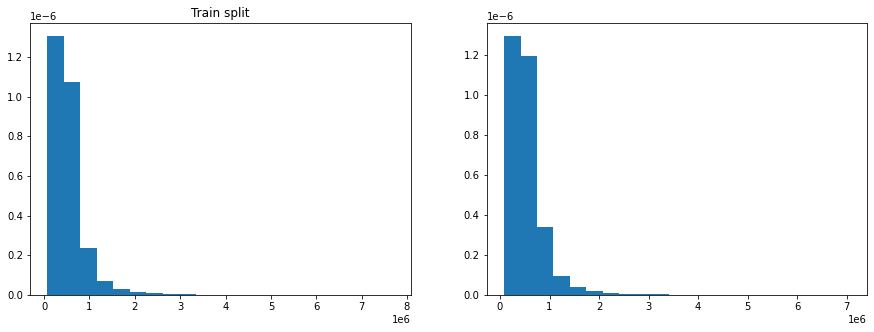

In [69]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].hist(y_train, density = True, bins = 21)
ax[0].set_title("Train split")
ax[1].hist(y_test, density = True, bins = 21)
ax[1].set_title("Test split")
plt.show()

In [94]:
print(f"   Train\tTest")
for i in range(1,22):
    print(f"{i}: {y_binned[y_train.index].value_counts()[i]}\t \t{y_binned[y_test.index].value_counts()[i]}")


   Train	Test
1: 121	 	52
2: 1582	 	678
3: 2934	 	1258
4: 2967	 	1272
5: 2127	 	911
6: 1753	 	751
7: 1077	 	462
8: 864	 	370
9: 463	 	199
10: 314	 	134
11: 146	 	63
12: 172	 	73
13: 111	 	48
14: 100	 	43
15: 53	 	23
16: 71	 	30
17: 46	 	20
18: 37	 	16
19: 31	 	13
20: 16	 	7
21: 144	 	61


I think the split is OK.

### The hyperparameters search

In [5]:
from sklearn.model_selection import GridSearchCV
import xgboost

In [139]:
parameters_grid = {
   'colsample_bytree':[0.4,0.6,0.8],
   'eta' : [0.10, 0.15, 0.20, 0.25, 0.30] ,
   'max_depth':[3,5, 8],
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
}
                    
xgb_model = xgboost.XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                       param_grid = parameters_grid, 
                       n_jobs=-1, 
                       verbose=10,
                       scoring='neg_mean_squared_error')

gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [142]:
print('best params')
print (gsearch.best_params_)
print('best score')
print (gsearch.best_score_)

best params
{'colsample_bytree': 0.6, 'eta': 0.15, 'gamma': 0.0, 'max_depth': 5}
best score
-14591587981.60199


In [6]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6, eta=0.15, max_depth=5, gamma=0,
                                 objective="reg:squarederror", random_state=1)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.15, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.150000006, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [7]:
y_hat = xgb_model.predict(X_test)
print(f"Mean absolute error on the test set: {abs(y_hat - y_test).mean()}")

Mean absolute error on the test set: 68372.00900413518


## Task 3 - SHAP decomposition

I select **three different observations** from training dataset: one whose **price is low**, one whose **price is near average** and whose **price is very high**.

In [8]:
import shap
shap.initjs()

In [9]:
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(X)

explainer = shap.TreeExplainer(xgb_model, X)
shap_values = explainer(X)

 99%|===================| 21446/21613 [01:06<00:00]        

### The 'cheap' example

In [146]:
y_train[y_train < 100000].index.values

array([10253,  1149, 10770,  5303, 12551, 18468, 10585,  3767, 14581,
       18939,  2141,  3108, 15293,   465,  5723, 17580, 16530,  3321,
       16198], dtype=int64)

In [11]:
cheap_house_idx = 465
X_train.loc[cheap_house_idx].to_frame().transpose()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
465,1.0,0.75,430.0,5050.0,1.0,0.0,0.0,2.0,4.0,430.0,0.0,1912.0,0.0,98014.0,47.6499,-121.909,1200.0,7500.0


In [192]:
y_pred = xgb_model.predict(X_train.loc[cheap_house_idx].to_frame().transpose())[0]

print(f"Prediction for the 'cheap' example: {y_pred :.0f}$")
print(f"The actual price: {y_train.loc[cheap_house_idx]:.0f}$")
print(f"The difference is {abs(y_pred - y_train.loc[cheap_house_idx]):.0f}$")

Prediction for the 'cheap' example: 171541$
The actual price: 80000$
The difference is 91541$


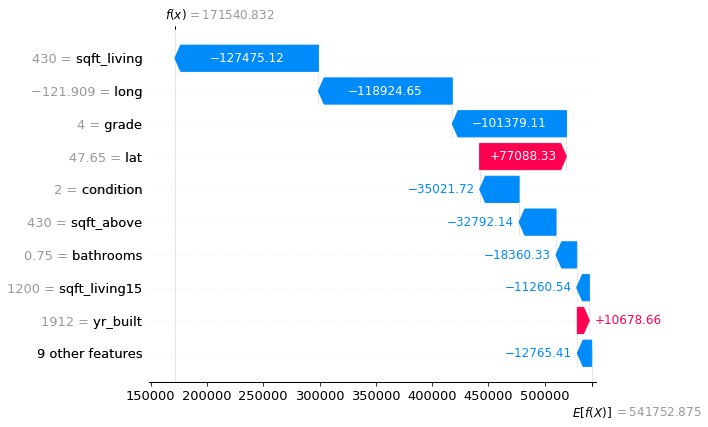

In [25]:
shap.plots.waterfall(shap_values[cheap_house_idx])

One can see that almost all variables has negative impact on this house's price. The variable which has positive impact is latitude=47.65. That might me explained by the fact that very expensive houses are gathered in the area where latitude is around 47.6. By longitude -121.9 makes this house little off the centre and that might be a reason why contributes negatively.

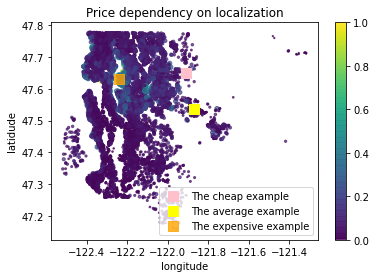

In [242]:
plt.scatter(house_data["long"], house_data["lat"], 
            c = house_data["price"], cmap = "viridis", alpha = 0.7,
            s = house_data["price"]/100000)
plt.scatter(X["long"].loc[cheap_house_idx], X["lat"].loc[cheap_house_idx],
           s = 100, marker = "s", c="pink", label="The cheap example")

plt.scatter(X["long"].loc[average_house_idx], X["lat"].loc[average_house_idx],
           s = 100, marker = "s", c="yellow", label="The average example")

plt.scatter(X["long"].loc[expensive_house_idx], X["lat"].loc[expensive_house_idx],
           s = 100, marker = "s", c="orange", label="The expensive example", alpha = 0.8)

plt.xlabel("longitude")
plt.ylabel("latidude")
plt.title("Price dependency on localization")
plt.colorbar()
plt.legend()
plt.show()

### 'Average' example

In [185]:
y_train[abs(y_train - 5.400881e+05) < 1000].index.values

array([ 8733, 18838,  3925, 20601,  6918, 19219,  5861, 10282, 17646,
        8777, 15751, 19315, 11090,  5552, 16338, 17108, 20715,  9205,
       10668,  5125, 19772,  5559, 20318, 18999, 16982, 17806,  4690,
       17441,  1631, 21560, 14288, 14007,  9566, 16692, 10999, 19936,
       20730, 12206,  8760,  2490, 15189, 13902,  9814,  4553,  7265,
        4672, 16797, 21311,  5023,  6091, 17876,  5823, 14563,  3559,
       14858, 18053,  2609, 19611, 12451,  6920, 13174,   862, 16840,
       20478, 16010,  7831, 10866,  3017, 19489, 13823, 15609, 12027,
       20549,  5435, 18317, 15444], dtype=int64)

In [12]:
average_house_idx = 18838
X_train.loc[average_house_idx].to_frame().transpose()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
18838,3.0,2.5,2400.0,5817.0,2.0,0.0,0.0,3.0,8.0,2400.0,0.0,1998.0,0.0,98065.0,47.5371,-121.87,2420.0,5817.0


In [216]:
y_pred = xgb_model.predict(X_train.loc[average_house_idx].to_frame().transpose())[0]

print(f"Prediction for the 'average' example: {y_pred :.0f}$")
print(f"The actual price: {y_train.loc[average_house_idx]:.0f}$")
print(f"The difference is {abs(y_pred - y_train.loc[average_house_idx]):.0f}$")

Prediction for the 'average' example: 515117$
The actual price: 540000$
The difference is 24883$


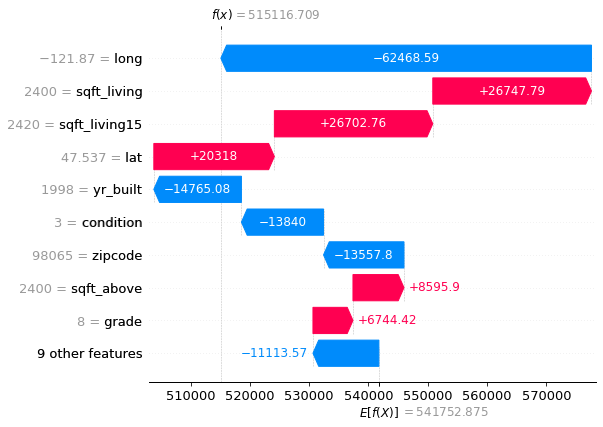

In [27]:
shap.plots.waterfall(shap_values[average_house_idx])

Similarly to the cheap example, geographical localization is very important in determining the price. The other important factor is square area. We can see that sqft_living and sqft_living15 are slighlty higher than the mean value.

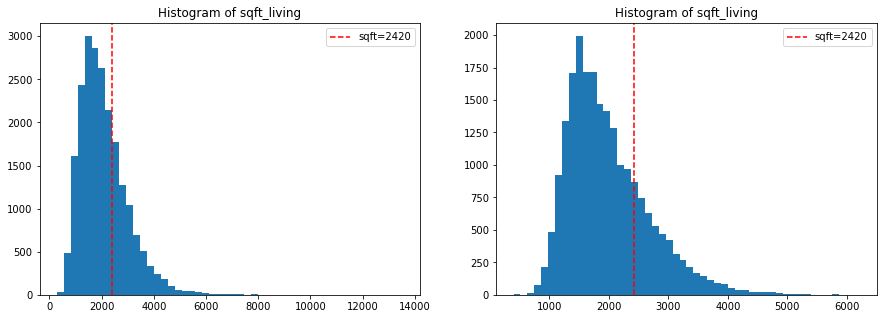

In [229]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(X["sqft_living"], bins = 50)
ax[0].set_title("Histogram of sqft_living")
ax[0].axvline(x=2400, ymin=0, ymax = 14000, label='sqft=2420', c="red", linestyle="--")
ax[0].legend()

ax[1].hist(X["sqft_living15"], bins = 50)
ax[1].set_title("Histogram of sqft_living15")
ax[1].axvline(x=2420, ymin=0, ymax = 14000, label='sqft=2420', c="red", linestyle="--")
ax[1].legend()

plt.show()

Grade and condition has substantial negative impact on the price. The impact of grade is easier to understand. Houses with grade higher than 8 has generally bigger prices (although there are some exceptions) as can be see on the graph.

Influence of condition is more hazy since both cheaper and pricier houses can have condion equal 3, 4 or 5. Condition equal 1 and 2 is not visible on the graph, because it is very rare.

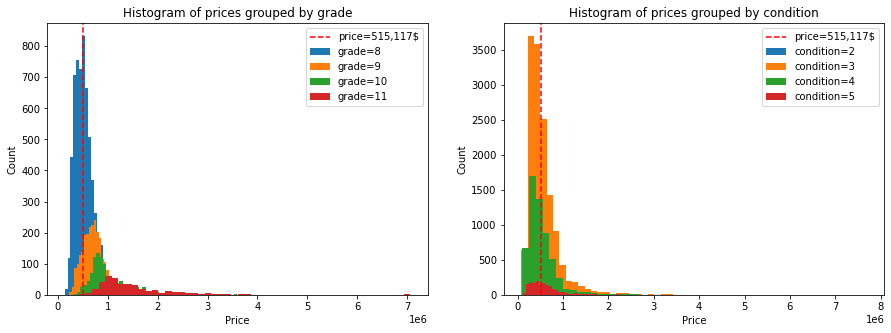

In [271]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

for i, grade in enumerate([8,9,10,11]):
    ax[0].hist(house_data.price[house_data.grade == grade], bins = 50, label=f"{grade=}")
    ax[0].set_title("Histogram of prices grouped by grade")
ax[0].axvline(x=515117, ymin=0, ymax = 3e+6, label='price=515,117$', c="red", linestyle="--")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Count")
ax[0].legend()


for i, condition in enumerate([2,3,4,5]):
    ax[1].hist(house_data.price[house_data["condition"] == condition], bins = 50, label=f"{condition=}")
    ax[1].set_title("Histogram of prices grouped by condition")
ax[1].axvline(x=515117, ymin=0, ymax = 3e+6, label='price=515,117$', c="red", linestyle="--")
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Count")
ax[1].legend()

plt.legend()
plt.show()

### The 'expensive' example

In [199]:
y_train[y_train > 6e+06].index.values

array([7252, 9254], dtype=int64)

In [13]:
expensive_house_idx = 9254
house_data.loc[expensive_house_idx].to_frame().transpose()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9254,9208900037,20140919T000000,6.885e+06,6,7.75,9890,31374,2,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.24,4540,42730


In [272]:
y_pred = xgb_model.predict(X_train.loc[expensive_house_idx].to_frame().transpose())[0]

print(f"Prediction for the 'expensive' example: {y_pred :.0f}$")
print(f"The actual price: {y_train.loc[expensive_house_idx]:.0f}$")
print(f"The difference is {abs(y_pred - y_train.loc[expensive_house_idx]):.0f}$")

Prediction for the 'expensive' example: 6834742$
The actual price: 6885000$
The difference is 50258$


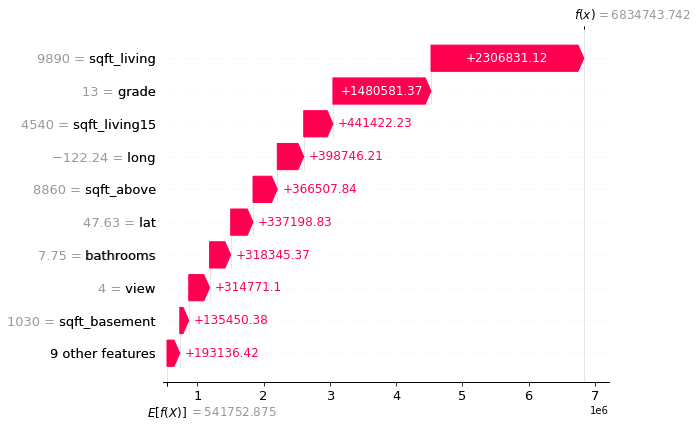

In [28]:
shap.plots.waterfall(shap_values[expensive_house_idx])

For the expensive house all the variables contributes positively in determining its price. The two most important are sqft_living which is high and the grade which has the highest possible value. Also geographical localization is important, as it was for the two previous examples.

## Task 4

### find two observations in the data set, such that they have different most important variables (e.g. age and gender are the most important for observation A, but race and class for observation B)

Sqft_living is the most important variable quite frequently. So in order to find an different example I looked for a house whose sqft_living shapley value was the lowest: 

In [71]:
sqft_living_idx = X.columns.get_loc("sqft_living")
np.argmin(np.abs(shap_values[:, sqft_living_idx].values))

14864

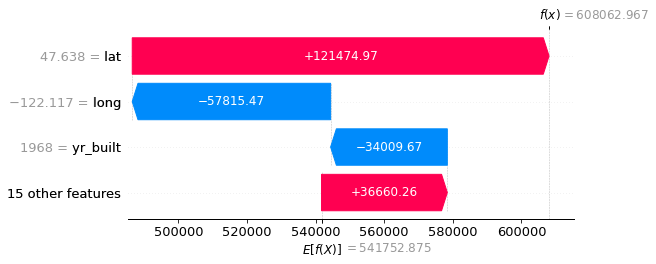

In [72]:
shap.plots.waterfall(shap_values[14864], max_display = 4)

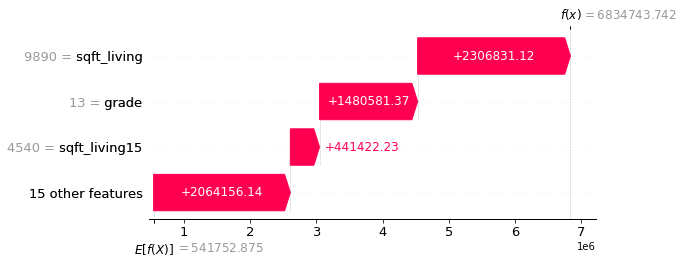

In [73]:
shap.plots.waterfall(shap_values[expensive_house_idx], max_display = 4)

Finding observations which differs in two most important variables wasn't so easy, because lot of observation has latitude in the most important variables and grade or sqft_living, as it is in the three previous examples: cheap, average and expensive.

This fact is not surprising, if we look at the graph of features importances: latitude, grade and sqft_living has the biggest impact on the predictions.

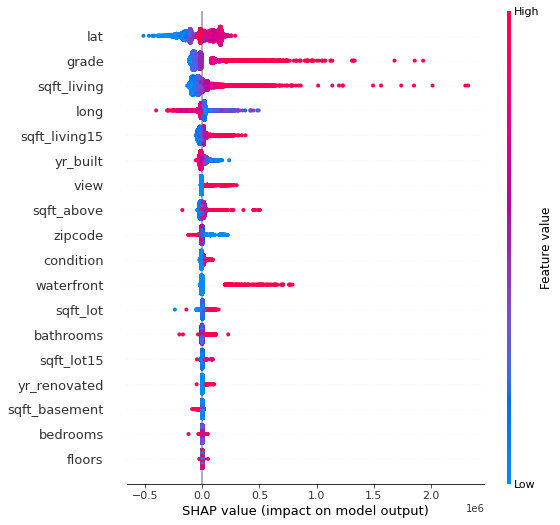

In [86]:
shap.summary_plot(shap_values, X)

## Task 5
### (if possible) select one variable and find two observations in the data set such that for one observation this variable has a positive effect and for the other a negative effect

That's easy, we can compare for example the cheap and expensive instance:

In [17]:
shap.plots.force(shap_values[cheap_house_idx])

In [16]:
shap.plots.force(shap_values[expensive_house_idx])

In thise case, all variables contribute positively for expensive house, but almost all contribute negatively for the cheap house. The impact of latitude and longitude is a little bit vague if we don't know the map of Seattle, but clearly sqft_living=430 and grade=4 belongs to the lowest possible values, so this comes as no surprise that they lower the price.

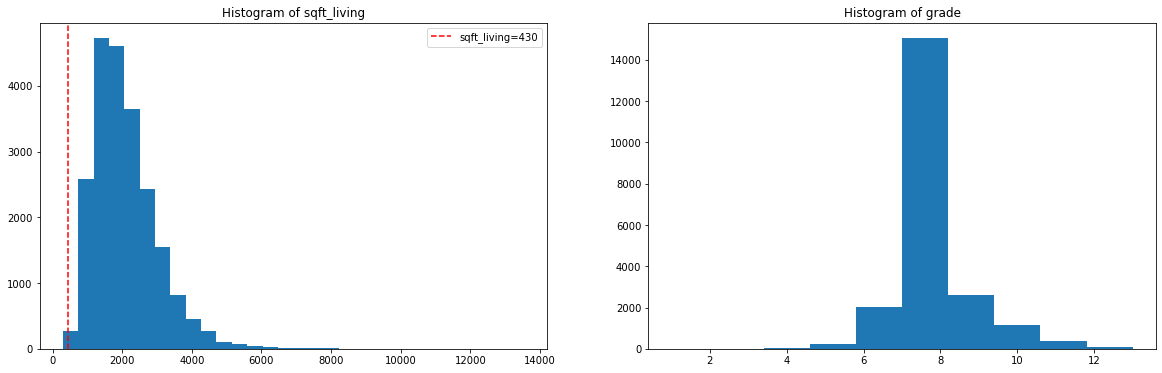

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (20,6))

ax[0].hist(X["sqft_living"], bins = 30)
ax[0].axvline(x=430, ymin=0, ymax = X["sqft_living"].max(),  label='sqft_living=430', c="red", linestyle="--")
ax[0].set_title("Histogram of sqft_living")
ax[0].legend()

ax[1].hist(X["grade"])
ax[1].set_title("Histogram of grade")

plt.show()

## Task 6